Forecasting Solar Radiation (Using Optuna & XGBoost)

In this regard, the building of a prediction model will be made out through this 2 frameworks.
The model itslef will be able to predict radiation patterns through a previous NASA dataset. In this case, we deliberatedly ignored the 'unix time stamp'. It could be useful if our data set needs a timestamp (Past Radiation data with an especifically time for a certain measure that needs to be the most accurate possible in a determined instant in future).

In [29]:
import numpy as np
import pandas as pd
import re ## REGULAR EXPRESIONS, truly needed when working with non-aligned data, so we can recall certain branches of them all that we can characterize/parametrize (EX: 1~12 / 1~31, mm-dd-yy)

from sklearn.preprocessing import StandardScaler ## removes the mean and scales each feature/variable to unit variance
from sklearn.model_selection import train_test_split ## dividing datasets into training and testing subsets (management of data)

import optuna ## automating the optimization process of hyperparameters (HPs) // automatically searches and finds the optimal HPs
import xgboost as xgb ## XGBoost algorithm // used for lecture optimization in cases of vastly raw data, improving the code reading

from sklearn.metrics import r2_score ## coefficient of determination (REGRESSION SCORE f(x))

In [30]:
data = pd.read_csv('SolarPrediction.csv')
data

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


Feature Engineering (REARRANGEMENT OF DATA)

In [32]:
print("Total Missing Values:", data.isna().sum().sum()) ## so the code itself will be able to report us about missing data, in booth columns and rows

Total Missing Values: 0


In [33]:
# so, no errors or missing values, nor columns neither rows
data['Month'] = data['Data'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(int)
data['Day'] = data['Data'].apply(lambda x: re.search(r'(?<=\/)\d+(?=\/)', x).group(0)).astype(int) ## LOOKAHEAD & LOOKBEHIND
data['Year'] = data['Data'].apply(lambda x: re.search(r'(?<=\/)\d+(?=\s)', x).group(0)).astype(int) ## Catching WHITE SPACE ---> WE DONT NEED IT... DROPING IT OUT, LOOK DOWN ON THE CODE
## astype(np.int) for homogenizing (from str to int)

# Now that we have date as separately functions, we can drop it from the data table
# don't worry about droping time, 'cause every data has been measured at 12 AM
data = data.drop('Data', axis=1) # axis 0/1 == index/columns

In [34]:
data['Hour'] = data['Time'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(int)
data['Minute'] = data['Time'].apply(lambda x: re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int) ## LOOKAHEAD & LOOKBEHIND
data['Second'] = data['Time'].apply(lambda x: re.search(r'\d+$', x).group(0)).astype(int) ## Catche WHITE SPACE
data = data.drop('Time', axis =1)
## just if we want, we can add time as columns again, but separately
## instead Hour == data['Hour']

In [35]:
data['SunriseHour'] = data['TimeSunRise'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(int)
data['SunriseMinute'] = data['TimeSunRise'].apply(lambda x: re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

data['SunsetHour'] = data['TimeSunSet'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(int)
data['SunsetMinute'] = data['TimeSunSet'].apply(lambda x: re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

data = data.drop(['TimeSunRise', 'TimeSunSet'], axis =1)
data

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Year,Hour,Minute,Second,SunriseHour,SunriseMinute,SunsetHour,SunsetMinute
0,1475229326,1.21,48,30.46,59,177.39,5.62,9,29,2016,23,55,26,6,13,18,13
1,1475229023,1.21,48,30.46,58,176.78,3.37,9,29,2016,23,50,23,6,13,18,13
2,1475228726,1.23,48,30.46,57,158.75,3.37,9,29,2016,23,45,26,6,13,18,13
3,1475228421,1.21,48,30.46,60,137.71,3.37,9,29,2016,23,40,21,6,13,18,13
4,1475228124,1.17,48,30.46,62,104.95,5.62,9,29,2016,23,35,24,6,13,18,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,1.22,44,30.43,102,145.42,6.75,12,1,2016,0,20,4,6,41,17,42
32682,1480587301,1.17,44,30.42,102,117.78,6.75,12,1,2016,0,15,1,6,41,17,42
32683,1480587001,1.20,44,30.42,102,145.19,9.00,12,1,2016,0,10,1,6,41,17,42
32684,1480586702,1.23,44,30.42,101,164.19,7.87,12,1,2016,0,5,2,6,41,17,42


In [36]:
data.dtypes

UNIXTime                    int64
Radiation                 float64
Temperature                 int64
Pressure                  float64
Humidity                    int64
WindDirection(Degrees)    float64
Speed                     float64
Month                       int32
Day                         int32
Year                        int32
Hour                        int32
Minute                      int32
Second                      int32
SunriseHour                 int32
SunriseMinute               int32
SunsetHour                  int32
SunsetMinute                int32
dtype: object

In [37]:
# before we can continue, year variable is the same, so we need to comprobe it
data['Year'].unique()

array([2016])

In [38]:
data['SunriseHour'].unique()

array([6])

In [39]:
## we can drop 'Year' from data, or erase it from above (2nd)
data = data.drop(['Year', 'SunriseHour'], axis = 1)

Splitting (Scaling)

In [40]:
## so, we don't wanna overwrite anything

Y = data['Radiation'].copy() ## Radiation --> comparative parameter
X = data.drop('Radiation', axis = 1).copy() ## Droping Radiation

In [41]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [42]:
## Validation Set (for training and fitting a learning model)

X_train , X_test , Y_train , Y_test = train_test_split(X, Y, train_size=0.7, random_state=100) ## 70% size || random seed as 100 'cause not setting a value will always randomize it
X_train , X_val , Y_train , Y_val = train_test_split(X_train,  Y_train, train_size=0.8, random_state=200) # 20% as a validiation set for our size


In [43]:
## let's scope the shape
print(X_train.shape[0]) ## EXAMPLES in our training set
print(X_test.shape[0]) ## EXAMPLES for our test set
print(X_val.shape[0]) ## EXAMPLES in our validation 

# nous pouvonz changer la mostre pour si la taille est plus reduit

18304
9806
4576


D MATRIX (XGBoost Data type used for performance optimization)

In [44]:
## D MATRIX for our previous train, test and validation sets
## similar to --> Pandas DFrame

dtrain = xgb.DMatrix(X_train, label=Y_train)
dval = xgb.DMatrix(X_val, label=Y_val)
dtest = xgb.DMatrix(X_test, label=Y_test)

Training

In [45]:
def get_model_rmse(params):
    ## let's consider evaluation as tuples in a list --> [ () ]
    model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'eval')], early_stopping_rounds=10, verbose_eval=0) ## n° of boost rounds
    ## we add a early stopping when reached 10 rounds w/o any improve
    ## Verbose turned off
    
    # storing the results --> eval() will evaluate a string and return an integer value
    results = model.eval(dval) #the results are taken out from the dval --> USUALLY is better to not change the test set
    # 'cause test is being biased bc of that eval // it's better to use other param rather than test set
    
    ##getting the RMSE with reg exp
    rmse = float(re.search(r'[\d.]+$', results).group(0))
    
    return rmse

In [46]:
        ## creating a test model || we test it once and then we forget about it
#   params = {'learning_rate': 0.01, 'max_depth': 6, 'alpha': 0.01, 'lambda': 1.0}
#   get_model_rmse(params)

In [47]:
## optuna for HPs optimization

## this f(x) objective iterates through finding loss values
def objective(trial): # creates new params and tests them out, 'til finds the lowest value possible
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 10 , log=True) ## we don't wanna int for the learning rate --> float preferably
    ## suggest_loguniform =  suggest_float(…, log=True) // loguniform is gonna be removed in a future version
    # in this case, suggest is gonna use lowered n° in continous distribution as l_rate
    # which is good cause is extremely sensitive to change at lower values (fast training)
    
    max_depth = trial.suggest_int('max_depth', 4, 8)    ## integer random number in range 4~8
    ## like a bounding ball 'cause the range of numbers are gonna change the training set at random
    
    l1_reg = trial.suggest_float('l1_reg', 0.0001, 10)    ## regularizations
    l2_reg = trial.suggest_float('l2_reg', 0.0001, 10)   ## regularizations
    
    # as a dictionary or set
    params = {'learning_rate': learning_rate, 'max_depth': max_depth, 'alpha': l1_reg, 'lambda': l2_reg} ## has to be the same name that XGB are gonna take
    
    return get_model_rmse(params)
    

In [48]:
study = optuna.create_study()
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-07-18 15:04:18,703] A new study created in memory with name: no-name-8f86f633-a8be-40b7-ab31-584e807c97e1
Best trial: 1. Best value: 95.8233:   2%|▏         | 2/100 [00:00<00:15,  6.15it/s]

[I 2024-07-18 15:04:18,872] Trial 0 finished with value: 289.95994586096606 and parameters: {'learning_rate': 0.0012853367210761547, 'max_depth': 4, 'l1_reg': 4.1723653569979104, 'l2_reg': 6.325368272047243}. Best is trial 0 with value: 289.95994586096606.
[I 2024-07-18 15:04:19,038] Trial 1 finished with value: 95.82325133757143 and parameters: {'learning_rate': 0.39406032034982075, 'max_depth': 4, 'l1_reg': 0.12168150094866213, 'l2_reg': 6.851477872710738}. Best is trial 1 with value: 95.82325133757143.


Best trial: 2. Best value: 88.891:   3%|▎         | 3/100 [00:00<00:28,  3.40it/s] 

[I 2024-07-18 15:04:19,488] Trial 2 finished with value: 88.89100202182735 and parameters: {'learning_rate': 0.04098022351772214, 'max_depth': 8, 'l1_reg': 6.889072629577934, 'l2_reg': 4.253100594752421}. Best is trial 2 with value: 88.89100202182735.


Best trial: 2. Best value: 88.891:   4%|▍         | 4/100 [00:01<00:26,  3.62it/s]

[I 2024-07-18 15:04:19,725] Trial 3 finished with value: 89.39706501658131 and parameters: {'learning_rate': 0.17858871640974913, 'max_depth': 6, 'l1_reg': 2.240234509197972, 'l2_reg': 8.357923087206322}. Best is trial 2 with value: 88.89100202182735.


Best trial: 2. Best value: 88.891:   5%|▌         | 5/100 [00:01<00:28,  3.37it/s]

[I 2024-07-18 15:04:20,063] Trial 4 finished with value: 92.57593054754363 and parameters: {'learning_rate': 0.03915179957451597, 'max_depth': 7, 'l1_reg': 0.1667910665458191, 'l2_reg': 4.3838212912241765}. Best is trial 2 with value: 88.89100202182735.


Best trial: 2. Best value: 88.891:   6%|▌         | 6/100 [00:01<00:31,  2.96it/s]

[I 2024-07-18 15:04:20,486] Trial 5 finished with value: 289.20418654865273 and parameters: {'learning_rate': 0.0011782557981431933, 'max_depth': 8, 'l1_reg': 4.916912914331829, 'l2_reg': 5.040175914836623}. Best is trial 2 with value: 88.89100202182735.


Best trial: 2. Best value: 88.891:   7%|▋         | 7/100 [00:02<00:28,  3.29it/s]

[I 2024-07-18 15:04:20,721] Trial 6 finished with value: 91.37016813813791 and parameters: {'learning_rate': 0.12337667539942276, 'max_depth': 6, 'l1_reg': 5.396236240342791, 'l2_reg': 0.6998677594548929}. Best is trial 2 with value: 88.89100202182735.
[I 2024-07-18 15:04:20,758] Trial 7 finished with value: 9601.956608649905 and parameters: {'learning_rate': 2.383137346037682, 'max_depth': 5, 'l1_reg': 3.2001602838460053, 'l2_reg': 2.874212627609292}. Best is trial 2 with value: 88.89100202182735.


Best trial: 2. Best value: 88.891:  10%|█         | 10/100 [00:02<00:19,  4.52it/s]

[I 2024-07-18 15:04:21,072] Trial 8 finished with value: 140.27348094164014 and parameters: {'learning_rate': 0.012426872075541042, 'max_depth': 7, 'l1_reg': 5.570233159734603, 'l2_reg': 8.972620744146715}. Best is trial 2 with value: 88.89100202182735.
[I 2024-07-18 15:04:21,237] Trial 9 finished with value: 102.63899671857888 and parameters: {'learning_rate': 0.11321555416698297, 'max_depth': 4, 'l1_reg': 1.3030352316289462, 'l2_reg': 9.19873136403857}. Best is trial 2 with value: 88.89100202182735.


Best trial: 2. Best value: 88.891:  11%|█         | 11/100 [00:03<00:24,  3.60it/s]

[I 2024-07-18 15:04:21,671] Trial 10 finished with value: 315.68571101469456 and parameters: {'learning_rate': 0.0001361497770297073, 'max_depth': 8, 'l1_reg': 8.64283364015341, 'l2_reg': 1.1646332623376385}. Best is trial 2 with value: 88.89100202182735.
[I 2024-07-18 15:04:21,737] Trial 11 finished with value: 1536862823991.596 and parameters: {'learning_rate': 8.73424857564458, 'max_depth': 6, 'l1_reg': 8.293399422912245, 'l2_reg': 7.578744664480132}. Best is trial 2 with value: 88.89100202182735.


[I 2024-07-18 15:04:22,088] Trial 12 finished with value: 185.69933222561318 and parameters: {'learning_rate': 0.00713705027005425, 'max_depth': 7, 'l1_reg': 6.785435031869238, 'l2_reg': 3.293225116650411}. Best is trial 2 with value: 88.89100202182735.


Best trial: 2. Best value: 88.891:  14%|█▍        | 14/100 [00:03<00:20,  4.25it/s]

[I 2024-07-18 15:04:22,287] Trial 13 finished with value: 97.88549973177238 and parameters: {'learning_rate': 0.7564090624324273, 'max_depth': 5, 'l1_reg': 2.6384654313531586, 'l2_reg': 5.555239729925117}. Best is trial 2 with value: 88.89100202182735.


Best trial: 2. Best value: 88.891:  15%|█▌        | 15/100 [00:03<00:19,  4.26it/s]

[I 2024-07-18 15:04:22,521] Trial 14 finished with value: 102.0393419390611 and parameters: {'learning_rate': 0.05109420420902924, 'max_depth': 5, 'l1_reg': 7.743102845036011, 'l2_reg': 3.0433452660319515}. Best is trial 2 with value: 88.89100202182735.


Best trial: 2. Best value: 88.891:  16%|█▌        | 16/100 [00:04<00:19,  4.34it/s]

[I 2024-07-18 15:04:22,721] Trial 15 finished with value: 91.23034481210235 and parameters: {'learning_rate': 0.46874422283767403, 'max_depth': 7, 'l1_reg': 9.999671055043367, 'l2_reg': 9.96806628881598}. Best is trial 2 with value: 88.89100202182735.


Best trial: 2. Best value: 88.891:  18%|█▊        | 18/100 [00:04<00:19,  4.12it/s]

[I 2024-07-18 15:04:23,163] Trial 16 finished with value: 205.43740482233386 and parameters: {'learning_rate': 0.005607392996816116, 'max_depth': 8, 'l1_reg': 2.4466015286696905, 'l2_reg': 7.757951685232127}. Best is trial 2 with value: 88.89100202182735.
[I 2024-07-18 15:04:23,299] Trial 17 finished with value: 128.87575616814672 and parameters: {'learning_rate': 1.8809992415879142, 'max_depth': 6, 'l1_reg': 6.616417747057114, 'l2_reg': 4.10812042605115}. Best is trial 2 with value: 88.89100202182735.


Best trial: 2. Best value: 88.891:  19%|█▉        | 19/100 [00:04<00:21,  3.73it/s]

[I 2024-07-18 15:04:23,630] Trial 18 finished with value: 89.2485715094282 and parameters: {'learning_rate': 0.16957940930811496, 'max_depth': 6, 'l1_reg': 3.79434575777693, 'l2_reg': 1.7746253403965362}. Best is trial 2 with value: 88.89100202182735.


Best trial: 2. Best value: 88.891:  20%|██        | 20/100 [00:05<00:23,  3.37it/s]

[I 2024-07-18 15:04:24,001] Trial 19 finished with value: 108.90621580351024 and parameters: {'learning_rate': 0.019816479619332843, 'max_depth': 7, 'l1_reg': 4.038682370363364, 'l2_reg': 1.8668915142608011}. Best is trial 2 with value: 88.89100202182735.


Best trial: 2. Best value: 88.891:  21%|██        | 21/100 [00:05<00:26,  2.98it/s]

[I 2024-07-18 15:04:24,431] Trial 20 finished with value: 286.9771303920798 and parameters: {'learning_rate': 0.0012560158094305474, 'max_depth': 8, 'l1_reg': 6.22627324377873, 'l2_reg': 2.065762074902536}. Best is trial 2 with value: 88.89100202182735.


Best trial: 2. Best value: 88.891:  22%|██▏       | 22/100 [00:06<00:25,  3.05it/s]

[I 2024-07-18 15:04:24,739] Trial 21 finished with value: 91.78741967022678 and parameters: {'learning_rate': 0.10810563373892869, 'max_depth': 6, 'l1_reg': 1.758516367843626, 'l2_reg': 0.38224865590301516}. Best is trial 2 with value: 88.89100202182735.


Best trial: 2. Best value: 88.891:  24%|██▍       | 24/100 [00:06<00:18,  4.03it/s]

[I 2024-07-18 15:04:24,996] Trial 22 finished with value: 92.32504059325478 and parameters: {'learning_rate': 0.26930186853692895, 'max_depth': 5, 'l1_reg': 4.026582122574133, 'l2_reg': 5.937105643936225}. Best is trial 2 with value: 88.89100202182735.
[I 2024-07-18 15:04:25,102] Trial 23 finished with value: 122.19286256393343 and parameters: {'learning_rate': 1.5240605328712324, 'max_depth': 6, 'l1_reg': 1.276967443632088, 'l2_reg': 4.1601335934648676}. Best is trial 2 with value: 88.89100202182735.


Best trial: 2. Best value: 88.891:  25%|██▌       | 25/100 [00:06<00:20,  3.64it/s]

[I 2024-07-18 15:04:25,439] Trial 24 finished with value: 95.11802249608121 and parameters: {'learning_rate': 0.049310969817117654, 'max_depth': 6, 'l1_reg': 3.2914991545890686, 'l2_reg': 2.006385229715258}. Best is trial 2 with value: 88.89100202182735.


Best trial: 25. Best value: 86.0157:  26%|██▌       | 26/100 [00:07<00:21,  3.38it/s]

[I 2024-07-18 15:04:25,785] Trial 25 finished with value: 86.01571671284275 and parameters: {'learning_rate': 0.21753132927183624, 'max_depth': 7, 'l1_reg': 4.666406968784457, 'l2_reg': 7.285840967282921}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  28%|██▊       | 28/100 [00:07<00:19,  3.64it/s]

[I 2024-07-18 15:04:26,255] Trial 26 finished with value: 242.10016760558085 and parameters: {'learning_rate': 0.003407158881330543, 'max_depth': 8, 'l1_reg': 4.920702342176728, 'l2_reg': 7.1796385921607}. Best is trial 25 with value: 86.01571671284275.
[I 2024-07-18 15:04:26,358] Trial 27 finished with value: 4634086356.26525 and parameters: {'learning_rate': 5.556747710693077, 'max_depth': 7, 'l1_reg': 7.444938764668663, 'l2_reg': 4.880008386260159}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  29%|██▉       | 29/100 [00:07<00:16,  4.29it/s]

[I 2024-07-18 15:04:26,496] Trial 28 finished with value: 103.119707601528 and parameters: {'learning_rate': 0.9979360637660639, 'max_depth': 7, 'l1_reg': 5.737307057563449, 'l2_reg': 3.3144916013646766}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  30%|███       | 30/100 [00:08<00:21,  3.25it/s]

[I 2024-07-18 15:04:26,984] Trial 29 finished with value: 104.34909899713479 and parameters: {'learning_rate': 0.020561466094200277, 'max_depth': 8, 'l1_reg': 4.450917637437265, 'l2_reg': 6.43888753188797}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  31%|███       | 31/100 [00:08<00:22,  3.09it/s]

[I 2024-07-18 15:04:27,340] Trial 30 finished with value: 87.69665399660954 and parameters: {'learning_rate': 0.22433191739888317, 'max_depth': 7, 'l1_reg': 3.3371826081522245, 'l2_reg': 5.543581085071121}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  32%|███▏      | 32/100 [00:08<00:22,  3.01it/s]

[I 2024-07-18 15:04:27,689] Trial 31 finished with value: 88.38268978545476 and parameters: {'learning_rate': 0.20084976020137874, 'max_depth': 7, 'l1_reg': 3.4805449043515795, 'l2_reg': 5.5032686037668}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  33%|███▎      | 33/100 [00:09<00:22,  2.98it/s]

[I 2024-07-18 15:04:28,031] Trial 32 finished with value: 90.66712606685957 and parameters: {'learning_rate': 0.4858622313765507, 'max_depth': 7, 'l1_reg': 3.5138850430936386, 'l2_reg': 6.530276401850465}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  34%|███▍      | 34/100 [00:09<00:27,  2.40it/s]

[I 2024-07-18 15:04:28,632] Trial 33 finished with value: 87.85805056730747 and parameters: {'learning_rate': 0.07049045381903116, 'max_depth': 8, 'l1_reg': 4.55551821378453, 'l2_reg': 5.296619392745651}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  35%|███▌      | 35/100 [00:10<00:28,  2.30it/s]

[I 2024-07-18 15:04:29,114] Trial 34 finished with value: 88.68413963447013 and parameters: {'learning_rate': 0.07995390420390844, 'max_depth': 7, 'l1_reg': 4.372318282187981, 'l2_reg': 5.632712624684271}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  36%|███▌      | 36/100 [00:10<00:27,  2.29it/s]

[I 2024-07-18 15:04:29,561] Trial 35 finished with value: 88.28367920550252 and parameters: {'learning_rate': 0.24791613132481732, 'max_depth': 8, 'l1_reg': 2.968237645982188, 'l2_reg': 5.074283731147385}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  37%|███▋      | 37/100 [00:11<00:25,  2.44it/s]

[I 2024-07-18 15:04:29,908] Trial 36 finished with value: 88.21185280561777 and parameters: {'learning_rate': 0.3653991510979154, 'max_depth': 8, 'l1_reg': 2.675738886307885, 'l2_reg': 4.925121395089773}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  39%|███▉      | 39/100 [00:11<00:18,  3.25it/s]

[I 2024-07-18 15:04:30,205] Trial 37 finished with value: 92.44022370363902 and parameters: {'learning_rate': 0.5493317414230535, 'max_depth': 8, 'l1_reg': 2.1226505591777034, 'l2_reg': 6.78855879225994}. Best is trial 25 with value: 86.01571671284275.
[I 2024-07-18 15:04:30,353] Trial 38 finished with value: 37835509.23488934 and parameters: {'learning_rate': 3.9574359908441066, 'max_depth': 8, 'l1_reg': 0.6410906951593871, 'l2_reg': 6.021612957736043}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  40%|████      | 40/100 [00:12<00:24,  2.43it/s]

[I 2024-07-18 15:04:31,002] Trial 39 finished with value: 87.60791704358937 and parameters: {'learning_rate': 0.0636804747503476, 'max_depth': 8, 'l1_reg': 4.716592474811037, 'l2_reg': 4.639100696405961}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  41%|████      | 41/100 [00:12<00:28,  2.10it/s]

[I 2024-07-18 15:04:31,636] Trial 40 finished with value: 87.06611581237783 and parameters: {'learning_rate': 0.06951959869752104, 'max_depth': 8, 'l1_reg': 4.73036296385617, 'l2_reg': 8.133090723571808}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  42%|████▏     | 42/100 [00:13<00:31,  1.86it/s]

[I 2024-07-18 15:04:32,304] Trial 41 finished with value: 87.37832307196604 and parameters: {'learning_rate': 0.06808931313217716, 'max_depth': 8, 'l1_reg': 4.96607121226642, 'l2_reg': 8.455423966557571}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  43%|████▎     | 43/100 [00:14<00:33,  1.69it/s]

[I 2024-07-18 15:04:33,033] Trial 42 finished with value: 90.55198375282896 and parameters: {'learning_rate': 0.03593257728449602, 'max_depth': 8, 'l1_reg': 5.869728928561656, 'l2_reg': 8.415213921626755}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  44%|████▍     | 44/100 [00:15<00:39,  1.42it/s]

[I 2024-07-18 15:04:33,993] Trial 43 finished with value: 99.4845500207349 and parameters: {'learning_rate': 0.02404476239524459, 'max_depth': 8, 'l1_reg': 5.213191383467134, 'l2_reg': 8.262509488762282}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  45%|████▌     | 45/100 [00:15<00:36,  1.50it/s]

[I 2024-07-18 15:04:34,583] Trial 44 finished with value: 89.4263137012336 and parameters: {'learning_rate': 0.07852231134088922, 'max_depth': 7, 'l1_reg': 4.913146153885878, 'l2_reg': 9.107800124239535}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  46%|████▌     | 46/100 [00:16<00:37,  1.44it/s]

[I 2024-07-18 15:04:35,336] Trial 45 finished with value: 146.65270301160413 and parameters: {'learning_rate': 0.011051923948244283, 'max_depth': 8, 'l1_reg': 5.291758480950719, 'l2_reg': 7.24602942356703}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  47%|████▋     | 47/100 [00:17<00:33,  1.59it/s]

[I 2024-07-18 15:04:35,808] Trial 46 finished with value: 88.55611806080273 and parameters: {'learning_rate': 0.14387584245978302, 'max_depth': 7, 'l1_reg': 6.243992362641624, 'l2_reg': 9.864689215738284}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  48%|████▊     | 48/100 [00:17<00:26,  1.99it/s]

[I 2024-07-18 15:04:36,021] Trial 47 finished with value: 98.47432105100339 and parameters: {'learning_rate': 0.8604439568607256, 'max_depth': 7, 'l1_reg': 4.658772939572157, 'l2_reg': 8.13065904983633}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  49%|████▉     | 49/100 [00:18<00:28,  1.77it/s]

[I 2024-07-18 15:04:36,722] Trial 48 finished with value: 92.22823419346923 and parameters: {'learning_rate': 0.03240585004237566, 'max_depth': 8, 'l1_reg': 3.836157544830775, 'l2_reg': 8.617770523068199}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  50%|█████     | 50/100 [00:18<00:30,  1.66it/s]

[I 2024-07-18 15:04:37,432] Trial 49 finished with value: 316.1569645247491 and parameters: {'learning_rate': 0.00012191512592533216, 'max_depth': 8, 'l1_reg': 5.88296385889844, 'l2_reg': 7.140876059107464}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  51%|█████     | 51/100 [00:19<00:25,  1.91it/s]

[I 2024-07-18 15:04:37,748] Trial 50 finished with value: 250.3043800732131 and parameters: {'learning_rate': 0.003367620420368114, 'max_depth': 4, 'l1_reg': 5.375597651660012, 'l2_reg': 9.522761891949374}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  52%|█████▏    | 52/100 [00:19<00:27,  1.74it/s]

[I 2024-07-18 15:04:38,453] Trial 51 finished with value: 87.49664539652599 and parameters: {'learning_rate': 0.06841900454654558, 'max_depth': 8, 'l1_reg': 4.632789882643986, 'l2_reg': 7.813898679582536}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  53%|█████▎    | 53/100 [00:20<00:28,  1.63it/s]

[I 2024-07-18 15:04:39,154] Trial 52 finished with value: 86.85076481322322 and parameters: {'learning_rate': 0.10020069612666127, 'max_depth': 8, 'l1_reg': 4.843986584881274, 'l2_reg': 8.058935853824792}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  54%|█████▍    | 54/100 [00:21<00:30,  1.53it/s]

[I 2024-07-18 15:04:39,913] Trial 53 finished with value: 87.74161490502354 and parameters: {'learning_rate': 0.05618243949509, 'max_depth': 8, 'l1_reg': 4.698875237699504, 'l2_reg': 7.804286272508066}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  55%|█████▌    | 55/100 [00:21<00:29,  1.53it/s]

[I 2024-07-18 15:04:40,556] Trial 54 finished with value: 86.63000414044947 and parameters: {'learning_rate': 0.10383548157103129, 'max_depth': 8, 'l1_reg': 4.227316293905712, 'l2_reg': 8.795849619241684}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  56%|█████▌    | 56/100 [00:22<00:28,  1.57it/s]

[I 2024-07-18 15:04:41,163] Trial 55 finished with value: 86.58791844943858 and parameters: {'learning_rate': 0.11630960839039771, 'max_depth': 8, 'l1_reg': 4.293499860557537, 'l2_reg': 8.736492032489101}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  57%|█████▋    | 57/100 [00:23<00:29,  1.44it/s]

[I 2024-07-18 15:04:41,993] Trial 56 finished with value: 86.52753080062679 and parameters: {'learning_rate': 0.11997456250342617, 'max_depth': 8, 'l1_reg': 4.161145627749876, 'l2_reg': 8.745840595293014}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  58%|█████▊    | 58/100 [00:23<00:28,  1.48it/s]

[I 2024-07-18 15:04:42,607] Trial 57 finished with value: 86.51282747360003 and parameters: {'learning_rate': 0.13044324890178616, 'max_depth': 8, 'l1_reg': 4.233531064654945, 'l2_reg': 8.841898458655598}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  59%|█████▉    | 59/100 [00:24<00:26,  1.52it/s]

[I 2024-07-18 15:04:43,238] Trial 58 finished with value: 86.25885964513736 and parameters: {'learning_rate': 0.13100510252181283, 'max_depth': 8, 'l1_reg': 4.0131886337587765, 'l2_reg': 8.76582468756223}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  60%|██████    | 60/100 [00:24<00:22,  1.81it/s]

[I 2024-07-18 15:04:43,543] Trial 59 finished with value: 88.96278341843602 and parameters: {'learning_rate': 0.3628960447132708, 'max_depth': 8, 'l1_reg': 4.14319088507247, 'l2_reg': 8.81943902206646}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  61%|██████    | 61/100 [00:25<00:22,  1.76it/s]

[I 2024-07-18 15:04:44,155] Trial 60 finished with value: 86.56230691129304 and parameters: {'learning_rate': 0.14812474502121106, 'max_depth': 8, 'l1_reg': 3.891112661176534, 'l2_reg': 9.423803901981557}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  62%|██████▏   | 62/100 [00:25<00:21,  1.79it/s]

[I 2024-07-18 15:04:44,689] Trial 61 finished with value: 86.37716323266262 and parameters: {'learning_rate': 0.14712963295019643, 'max_depth': 8, 'l1_reg': 3.6878000966161353, 'l2_reg': 9.388904084482046}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  63%|██████▎   | 63/100 [00:26<00:20,  1.80it/s]

[I 2024-07-18 15:04:45,234] Trial 62 finished with value: 87.31040471100026 and parameters: {'learning_rate': 0.14592107236340532, 'max_depth': 8, 'l1_reg': 3.7310496314591806, 'l2_reg': 9.562450271003673}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  64%|██████▍   | 64/100 [00:26<00:18,  1.91it/s]

[I 2024-07-18 15:04:45,689] Trial 63 finished with value: 87.44182361995148 and parameters: {'learning_rate': 0.23922036979253705, 'max_depth': 8, 'l1_reg': 2.809352248412327, 'l2_reg': 9.343292830106153}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  65%|██████▌   | 65/100 [00:27<00:19,  1.83it/s]

[I 2024-07-18 15:04:46,291] Trial 64 finished with value: 313.8768447209524 and parameters: {'learning_rate': 0.0002081457692117038, 'max_depth': 8, 'l1_reg': 3.0017753611817177, 'l2_reg': 9.753268805451729}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  66%|██████▌   | 66/100 [00:27<00:17,  1.97it/s]

[I 2024-07-18 15:04:46,686] Trial 65 finished with value: 87.85134455638953 and parameters: {'learning_rate': 0.3321241282447822, 'max_depth': 7, 'l1_reg': 3.704807366606223, 'l2_reg': 9.149344712549556}. Best is trial 25 with value: 86.01571671284275.


[I 2024-07-18 15:04:47,278] Trial 66 finished with value: 86.75476175151991 and parameters: {'learning_rate': 0.14172644139156268, 'max_depth': 8, 'l1_reg': 3.947671536189314, 'l2_reg': 8.756294127384198}. Best is trial 25 with value: 86.01571671284275.


[I 2024-07-18 15:04:47,468] Trial 67 finished with value: 94.94835898838477 and parameters: {'learning_rate': 0.6175779908385033, 'max_depth': 7, 'l1_reg': 3.128605492271389, 'l2_reg': 9.351103730114552}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  69%|██████▉   | 69/100 [00:28<00:11,  2.81it/s]

[I 2024-07-18 15:04:47,653] Trial 68 finished with value: 107.30705583079397 and parameters: {'learning_rate': 1.3801773577945415, 'max_depth': 8, 'l1_reg': 4.2706478081557755, 'l2_reg': 7.4387198461800494}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  70%|███████   | 70/100 [00:29<00:13,  2.31it/s]

[I 2024-07-18 15:04:48,274] Trial 69 finished with value: 86.12976792333212 and parameters: {'learning_rate': 0.17736657935013136, 'max_depth': 8, 'l1_reg': 3.5556904236463, 'l2_reg': 9.007618515003195}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  71%|███████   | 71/100 [00:30<00:13,  2.15it/s]

[I 2024-07-18 15:04:48,806] Trial 70 finished with value: 87.87773664402897 and parameters: {'learning_rate': 0.18221702590792604, 'max_depth': 7, 'l1_reg': 2.1427055582188297, 'l2_reg': 9.034803500157023}. Best is trial 25 with value: 86.01571671284275.


Best trial: 25. Best value: 86.0157:  72%|███████▏  | 72/100 [00:30<00:14,  1.97it/s]

[I 2024-07-18 15:04:49,422] Trial 71 finished with value: 86.36090994963388 and parameters: {'learning_rate': 0.19284915394168692, 'max_depth': 8, 'l1_reg': 3.352428574366874, 'l2_reg': 9.57105758550647}. Best is trial 25 with value: 86.01571671284275.


Best trial: 72. Best value: 85.9244:  73%|███████▎  | 73/100 [00:31<00:14,  1.87it/s]

[I 2024-07-18 15:04:50,024] Trial 72 finished with value: 85.92441595470564 and parameters: {'learning_rate': 0.28968938400288985, 'max_depth': 8, 'l1_reg': 3.3280242942293206, 'l2_reg': 9.422905708194731}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  74%|███████▍  | 74/100 [00:31<00:14,  1.79it/s]

[I 2024-07-18 15:04:50,638] Trial 73 finished with value: 87.26787886333831 and parameters: {'learning_rate': 0.3124013670864721, 'max_depth': 8, 'l1_reg': 2.3873744768218264, 'l2_reg': 9.88304262434107}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  75%|███████▌  | 75/100 [00:32<00:12,  1.95it/s]

[I 2024-07-18 15:04:51,024] Trial 74 finished with value: 88.03481783055473 and parameters: {'learning_rate': 0.47373880613561975, 'max_depth': 8, 'l1_reg': 3.482484664290318, 'l2_reg': 9.178906875056066}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  76%|███████▌  | 76/100 [00:32<00:10,  2.24it/s]

[I 2024-07-18 15:04:51,327] Trial 75 finished with value: 93.48318152661983 and parameters: {'learning_rate': 0.668016993706392, 'max_depth': 8, 'l1_reg': 1.7265771518279218, 'l2_reg': 9.640090687637377}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  77%|███████▋  | 77/100 [00:33<00:11,  1.92it/s]

[I 2024-07-18 15:04:52,023] Trial 76 finished with value: 89.00999560171084 and parameters: {'learning_rate': 0.04461086761614321, 'max_depth': 8, 'l1_reg': 3.185555766089943, 'l2_reg': 8.388218813532932}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  78%|███████▊  | 78/100 [00:33<00:10,  2.16it/s]

[I 2024-07-18 15:04:52,348] Trial 77 finished with value: 93.85015651941303 and parameters: {'learning_rate': 0.23961270706749985, 'max_depth': 5, 'l1_reg': 3.480989357543157, 'l2_reg': 9.959622000817848}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  79%|███████▉  | 79/100 [00:33<00:08,  2.59it/s]

[I 2024-07-18 15:04:52,555] Trial 78 finished with value: 103.66113133265681 and parameters: {'learning_rate': 1.044721468283731, 'max_depth': 8, 'l1_reg': 2.7050729178354187, 'l2_reg': 8.574832217626769}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  80%|████████  | 80/100 [00:34<00:08,  2.46it/s]

[I 2024-07-18 15:04:53,004] Trial 79 finished with value: 86.37335049527161 and parameters: {'learning_rate': 0.19160735494545192, 'max_depth': 8, 'l1_reg': 9.636871477310159, 'l2_reg': 9.023312802736214}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  81%|████████  | 81/100 [00:34<00:07,  2.38it/s]

[I 2024-07-18 15:04:53,454] Trial 80 finished with value: 87.73308243840135 and parameters: {'learning_rate': 0.19687646576601228, 'max_depth': 8, 'l1_reg': 9.963862972127288, 'l2_reg': 8.954078929788372}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  82%|████████▏ | 82/100 [00:35<00:08,  2.02it/s]

[I 2024-07-18 15:04:54,125] Trial 81 finished with value: 86.94958305343475 and parameters: {'learning_rate': 0.09670223397936081, 'max_depth': 8, 'l1_reg': 7.243667643007605, 'l2_reg': 9.310955256195335}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  83%|████████▎ | 83/100 [00:36<00:08,  1.91it/s]

[I 2024-07-18 15:04:54,725] Trial 82 finished with value: 86.98112876976072 and parameters: {'learning_rate': 0.25968842889480653, 'max_depth': 8, 'l1_reg': 3.6467162492854115, 'l2_reg': 9.67622887133097}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  84%|████████▍ | 84/100 [00:36<00:07,  2.08it/s]

[I 2024-07-18 15:04:55,108] Trial 83 finished with value: 88.94242340593732 and parameters: {'learning_rate': 0.3691947241668995, 'max_depth': 8, 'l1_reg': 8.542228245632277, 'l2_reg': 7.918919249110787}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  85%|████████▌ | 85/100 [00:36<00:07,  2.06it/s]

[I 2024-07-18 15:04:55,602] Trial 84 finished with value: 86.6444981467353 and parameters: {'learning_rate': 0.1689089256095975, 'max_depth': 8, 'l1_reg': 9.383823278463332, 'l2_reg': 8.974349994451707}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  86%|████████▌ | 86/100 [00:37<00:07,  1.85it/s]

[I 2024-07-18 15:04:56,261] Trial 85 finished with value: 97.2517846465304 and parameters: {'learning_rate': 0.025324999987731033, 'max_depth': 8, 'l1_reg': 5.17466851520234, 'l2_reg': 7.572454888752813}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  87%|████████▋ | 87/100 [00:37<00:06,  2.01it/s]

[I 2024-07-18 15:04:56,659] Trial 86 finished with value: 89.09376943744257 and parameters: {'learning_rate': 0.4800417167961465, 'max_depth': 8, 'l1_reg': 4.035393275300594, 'l2_reg': 8.282146207290339}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  88%|████████▊ | 88/100 [00:38<00:06,  1.82it/s]

[I 2024-07-18 15:04:57,321] Trial 87 finished with value: 86.96244853380038 and parameters: {'learning_rate': 0.11568636648957231, 'max_depth': 8, 'l1_reg': 2.9672306287971537, 'l2_reg': 8.580118813764228}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  89%|████████▉ | 89/100 [00:39<00:05,  1.87it/s]

[I 2024-07-18 15:04:57,842] Trial 88 finished with value: 93.06655672022994 and parameters: {'learning_rate': 0.03937905062155198, 'max_depth': 7, 'l1_reg': 3.331271253731299, 'l2_reg': 9.50146776561089}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  90%|█████████ | 90/100 [00:39<00:04,  2.07it/s]

[I 2024-07-18 15:04:58,202] Trial 89 finished with value: 88.44238351996431 and parameters: {'learning_rate': 0.3064149433727764, 'max_depth': 8, 'l1_reg': 7.917992579192496, 'l2_reg': 9.181643290666445}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  91%|█████████ | 91/100 [00:40<00:04,  2.00it/s]

[I 2024-07-18 15:04:58,725] Trial 90 finished with value: 89.21388047703364 and parameters: {'learning_rate': 0.0929842006131116, 'max_depth': 7, 'l1_reg': 4.432125258924589, 'l2_reg': 3.818713353198839}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  92%|█████████▏| 92/100 [00:40<00:03,  2.04it/s]

[I 2024-07-18 15:04:59,204] Trial 91 finished with value: 87.20987765624325 and parameters: {'learning_rate': 0.16457841890145578, 'max_depth': 8, 'l1_reg': 3.86798856735515, 'l2_reg': 9.462055651186693}. Best is trial 72 with value: 85.92441595470564.


Best trial: 72. Best value: 85.9244:  93%|█████████▎| 93/100 [00:40<00:03,  2.05it/s]

[I 2024-07-18 15:04:59,678] Trial 92 finished with value: 88.03209075469074 and parameters: {'learning_rate': 0.13957754458217156, 'max_depth': 8, 'l1_reg': 4.046041424837226, 'l2_reg': 8.916090706702565}. Best is trial 72 with value: 85.92441595470564.


Best trial: 93. Best value: 85.4385:  94%|█████████▍| 94/100 [00:41<00:03,  1.90it/s]

[I 2024-07-18 15:05:00,309] Trial 93 finished with value: 85.43852383576491 and parameters: {'learning_rate': 0.20666065449597942, 'max_depth': 8, 'l1_reg': 4.446003894089376, 'l2_reg': 9.682466192327775}. Best is trial 93 with value: 85.43852383576491.


Best trial: 93. Best value: 85.4385:  95%|█████████▌| 95/100 [00:42<00:02,  1.89it/s]

[I 2024-07-18 15:05:00,824] Trial 94 finished with value: 86.23964689312129 and parameters: {'learning_rate': 0.22791309272377747, 'max_depth': 8, 'l1_reg': 5.085055065856688, 'l2_reg': 9.960607672782714}. Best is trial 93 with value: 85.43852383576491.


Best trial: 93. Best value: 85.4385:  96%|█████████▌| 96/100 [00:42<00:02,  1.82it/s]

[I 2024-07-18 15:05:01,425] Trial 95 finished with value: 86.66036501122942 and parameters: {'learning_rate': 0.19724488526762485, 'max_depth': 8, 'l1_reg': 6.395036188474816, 'l2_reg': 9.999340409004922}. Best is trial 93 with value: 85.43852383576491.


Best trial: 93. Best value: 85.4385:  97%|█████████▋| 97/100 [00:43<00:01,  2.07it/s]

[I 2024-07-18 15:05:01,769] Trial 96 finished with value: 88.69906489898433 and parameters: {'learning_rate': 0.43327437109063016, 'max_depth': 8, 'l1_reg': 5.49677112706567, 'l2_reg': 9.755833573012636}. Best is trial 93 with value: 85.43852383576491.


[I 2024-07-18 15:05:02,165] Trial 97 finished with value: 89.41149915500445 and parameters: {'learning_rate': 0.27670053616643703, 'max_depth': 6, 'l1_reg': 0.18292864116364527, 'l2_reg': 9.682008312760255}. Best is trial 93 with value: 85.43852383576491.


Best trial: 93. Best value: 85.4385:  99%|█████████▉| 99/100 [00:43<00:00,  2.60it/s]

[I 2024-07-18 15:05:02,366] Trial 98 finished with value: 97.06031216318439 and parameters: {'learning_rate': 0.8721436872656166, 'max_depth': 8, 'l1_reg': 5.034149479811252, 'l2_reg': 9.10564035397918}. Best is trial 93 with value: 85.43852383576491.


Best trial: 93. Best value: 85.4385: 100%|██████████| 100/100 [00:44<00:00,  2.26it/s]

[I 2024-07-18 15:05:03,025] Trial 99 finished with value: 87.05614766276234 and parameters: {'learning_rate': 0.08765114021866122, 'max_depth': 8, 'l1_reg': 4.44849013399636, 'l2_reg': 9.298214919044092}. Best is trial 93 with value: 85.43852383576491.


In [49]:
best_params = study.best_params
best_params

{'learning_rate': 0.20666065449597942,
 'max_depth': 8,
 'l1_reg': 4.446003894089376,
 'l2_reg': 9.682466192327775}

In [50]:
model = xgb.train(best_params, dtrain, num_boost_round=10000, evals=[(dval, 'eval')], early_stopping_rounds=10)

[0]	eval-rmse:262.80603
[1]	eval-rmse:218.81887
[2]	eval-rmse:185.41559
[3]	eval-rmse:159.64383
[4]	eval-rmse:141.09362
[5]	eval-rmse:126.85112


[6]	eval-rmse:116.20405
[7]	eval-rmse:108.84511
[8]	eval-rmse:103.44009
[9]	eval-rmse:99.73467
[10]	eval-rmse:96.78771
[11]	eval-rmse:94.56024
[12]	eval-rmse:93.41001
[13]	eval-rmse:92.19783


c:\Users\lcsvi\OneDrive\Escritorio\Pyth\Data Analysis\datos\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:05:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "l1_reg", "l2_reg" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	eval-rmse:91.48511
[15]	eval-rmse:90.77441
[16]	eval-rmse:90.50850
[17]	eval-rmse:90.24987
[18]	eval-rmse:90.19329
[19]	eval-rmse:89.92472
[20]	eval-rmse:89.50411
[21]	eval-rmse:89.38105
[22]	eval-rmse:89.26922
[23]	eval-rmse:89.27587
[24]	eval-rmse:89.34785
[25]	eval-rmse:89.15422
[26]	eval-rmse:89.08932
[27]	eval-rmse:89.05550
[28]	eval-rmse:88.87422
[29]	eval-rmse:88.73927
[30]	eval-rmse:88.76886
[31]	eval-rmse:88.68097
[32]	eval-rmse:88.68041
[33]	eval-rmse:88.59029
[34]	eval-rmse:88.58695
[35]	eval-rmse:88.59400
[36]	eval-rmse:88.53543
[37]	eval-rmse:88.55800
[38]	eval-rmse:88.55571
[39]	eval-rmse:88.40981
[40]	eval-rmse:88.43158
[41]	eval-rmse:88.35396
[42]	eval-rmse:88.40008
[43]	eval-rmse:88.46141
[44]	eval-rmse:88.52267
[45]	eval-rmse:88.61876
[46]	eval-rmse:88.52290
[47]	eval-rmse:88.44955
[48]	eval-rmse:88.47202
[49]	eval-rmse:88.43945
[50]	eval-rmse:88.39422
[51]	eval-rmse:88.31514
[52]	eval-rmse:88.20750
[53]	eval-rmse:88.14184
[54]	eval-rmse:88.12914
[55]	eval-rmse:8

Results

In [51]:
Y_true = np.array(Y_test, dtype=float) ## our OG Radiation values
Y_pred = np.array(model.predict(dtest), dtype=float)
Y_true

array([1.22, 1.22, 1.21, ..., 1.22, 1.22, 1.24])

In [52]:
r2 = r2_score(Y_true, Y_pred)

print('R^2 Score: %4f ' % r2) ## --> formating number 'til 4 digits

R^2 Score: 0.939154 


In [53]:
Y_pred

array([ 0.99160218,  9.06472969, -0.96306121, ..., 20.21638489,
        2.90693688,  7.18087435])

Visualization

In [54]:
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

In [55]:
data.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,SunriseMinute,SunsetHour,SunsetMinute
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869,10.526066,15.825766,11.557425,27.556691,17.441902,27.640519,17.347886,37.317904
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474,1.096691,8.711824,6.912034,17.268507,12.951109,15.518714,0.476307,15.938416
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,7.000000,17.000000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000,10.000000,9.000000,6.000000,15.000000,5.000000,14.000000,17.000000,26.000000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000,11.000000,16.000000,12.000000,30.000000,18.000000,24.000000,17.000000,43.000000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000,11.000000,23.000000,18.000000,45.000000,22.000000,40.000000,18.000000,48.000000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000,12.000000,31.000000,23.000000,57.000000,59.000000,57.000000,18.000000,59.000000


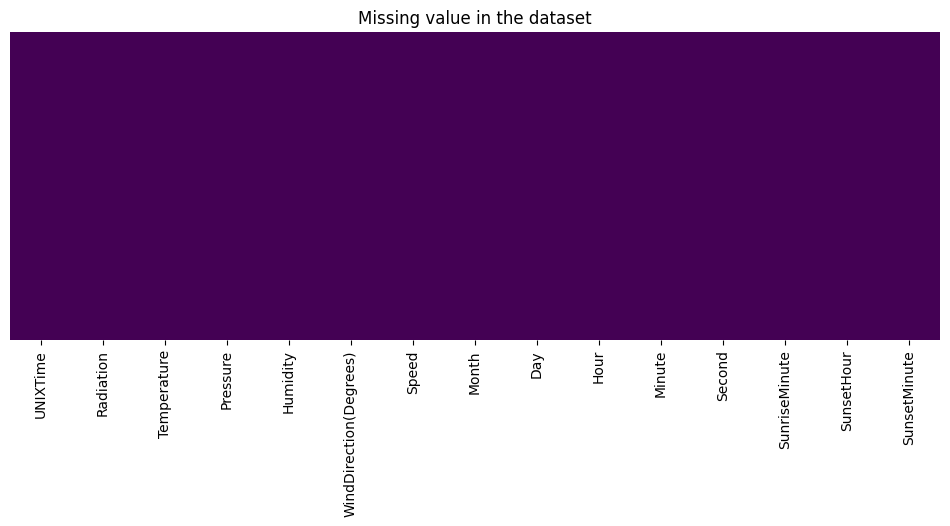

In [56]:
plt.figure(figsize=(12,4))
sns.heatmap(data.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing value in the dataset');

<Axes: >

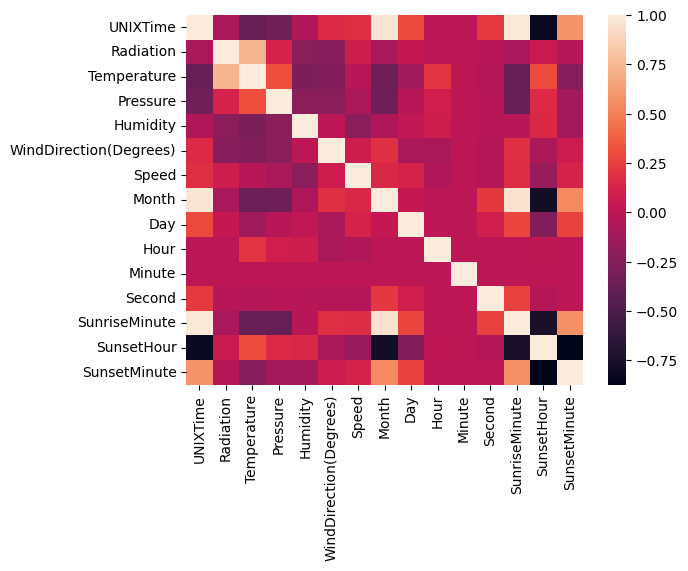

In [57]:
corr = data.corr() ## Correlation btwn data
sns.heatmap(corr)

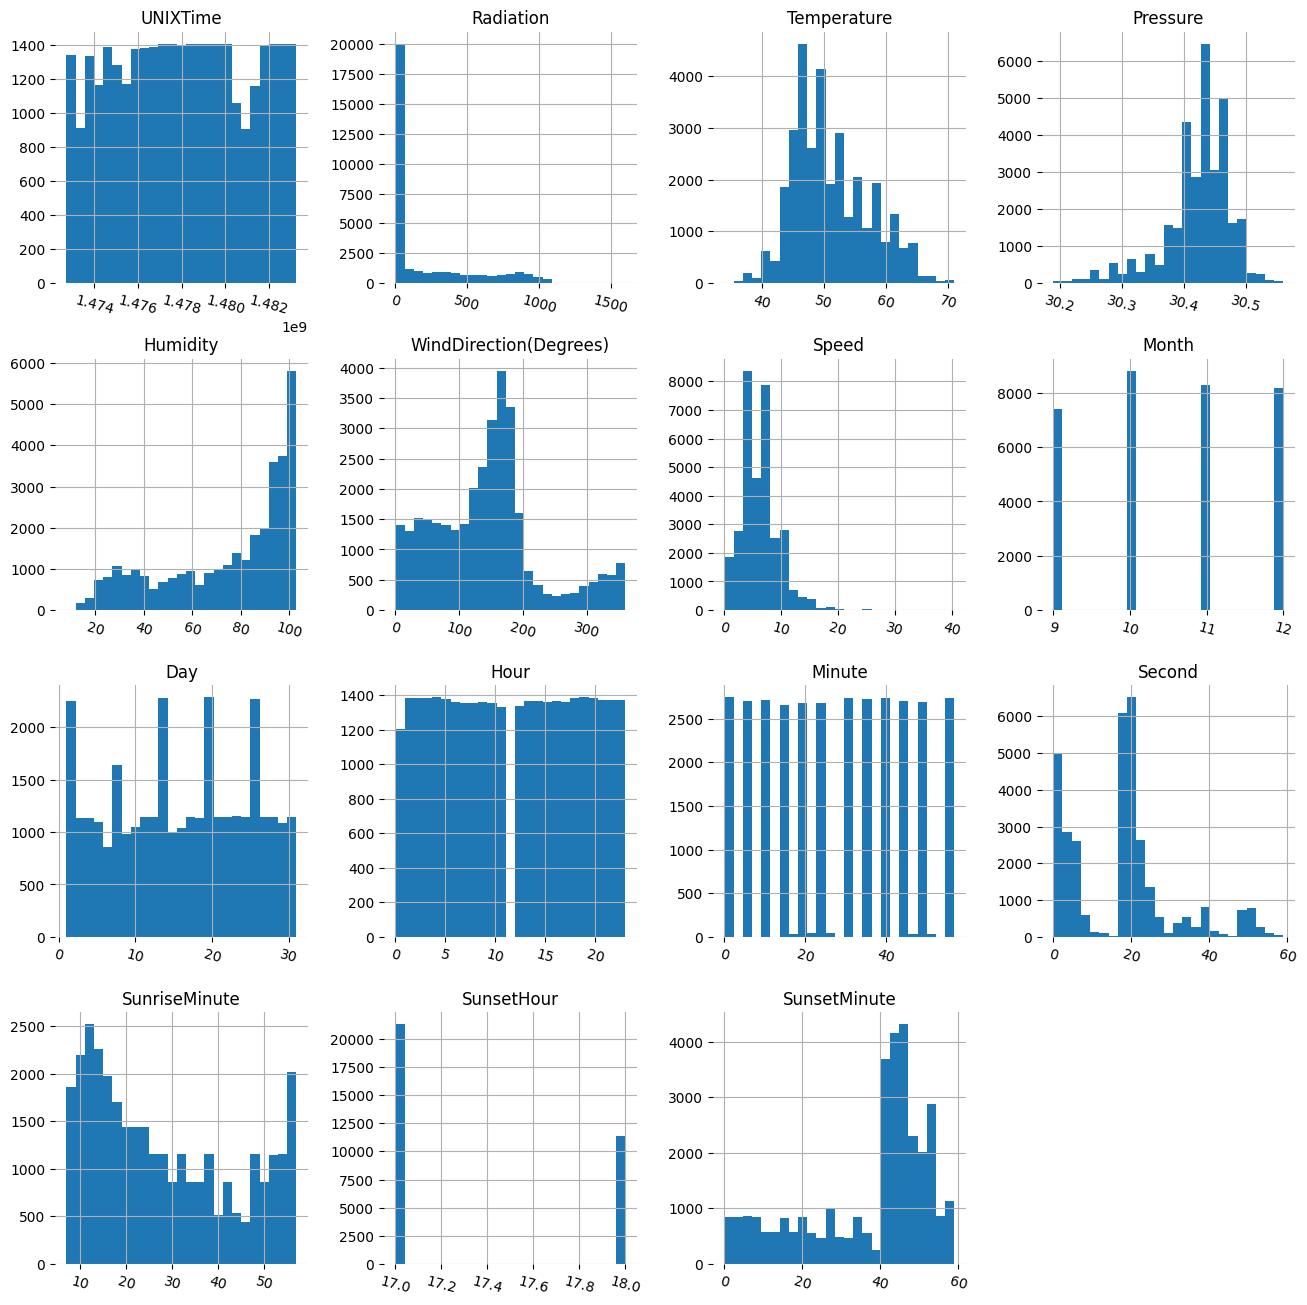

In [58]:
h = data.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

Model Bulding using Linear Regression

In [66]:
from sklearn.linear_model import LinearRegression 

Xlr = X_train
Ylr = Y_train
Xts= X_test
Yts= Y_test

lmodel = LinearRegression() 
lmodel.fit(Xlr,Ylr)

LinearRegression()

In [67]:
predicts = lmodel.predict(Xts)

### R_square 
sse = np.sum((predicts - Yts)**2)
sst = np.sum((Yts - Yts.mean())**2)
R_square = 1 - (sse/sst)
print('R square obtain for normal equation method is :',R_square)

R square obtain for normal equation method is : 0.6313621786543395


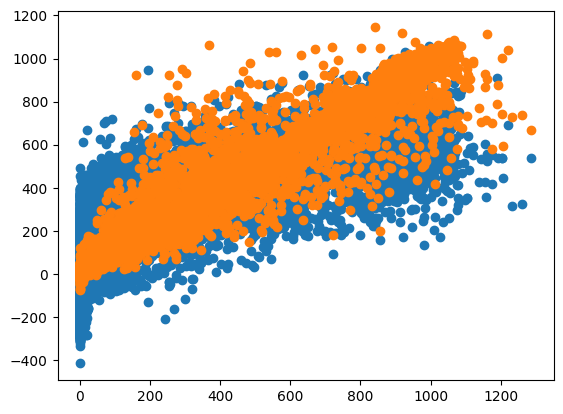

In [75]:
# Scattering of Linear Regression (Blue)
plt.scatter(Yts,predicts)

## Scattering of predictions having used previously our D-Matrix Model (Orange)
plt.scatter(Y_test,Y_pred)

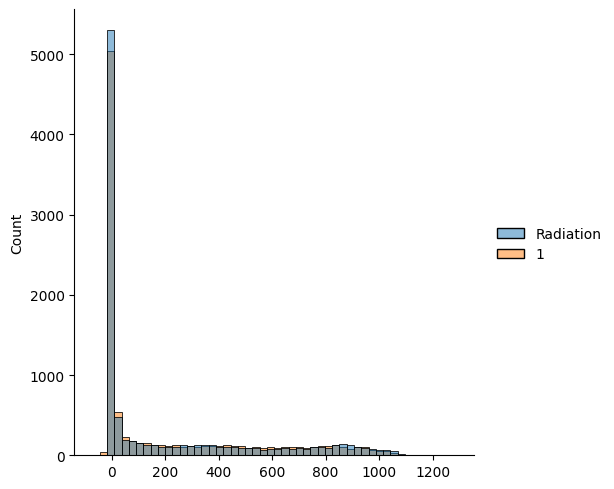

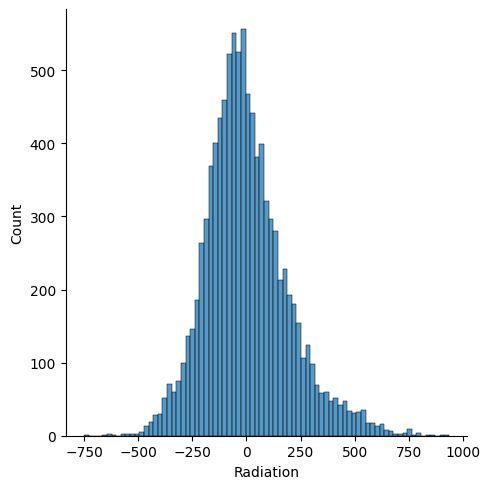

In [77]:
sns.displot((Y_test,Y_pred))
sns.displot((Yts-predicts))

In [64]:
## pd.DataFrame(X)